# 03 Algorithms

## 3.1 Value Iteration

### The Matrix-Vector form of Value Iteration
根据Bellman Optimal Equation，我们需要解决如下最优方程：
$$
v = f(v) \overset{\cdot}= \max_{\pi \in \prod}(r_{\pi} + \gamma P_{\pi} v)
$$

并且我们给出了求解从任意$v_0$开始，进行价值迭代的公式：
$$
v_{k+1} = f(v_k) = \max_{\pi \in \prod}(r_{\pi} + \gamma P_{\pi} v_k), \ \ \ k=0,1,2,...
$$
这一迭代过程，被称为价值迭代（Value Iteration）。
**Value Iteration** 算法是强化学习一个很重要的基础算法，其在每一次迭代过程有两个重要的步骤：
- **Plolicy Update(PU)：** 目标是寻找一个策略能够解决如下最优化问题$$
\pi_{k+1} = \arg \max (r_{\pi} + \gamma P_{\pi}v_k)$$，其中$v_k$是当前已迭代的状态价值；
- **Value Update(VU)：** 计算新的状态价值$v_{k+1}$通过价值迭代公式$$v_{k+1}=r_{\pi_{k+1}} + \gamma P_{\pi_{k+1}} v_k$$

### The Elementwise form of Value Iteration
#### **Policy Update**
在某状态$s$下的时间步$k$，Policy Update(PU) $
\pi_{k+1} = \arg \max (r_{\pi} + \gamma P_{\pi}v_k)$的元素形式可以表示为：
$$
\pi_{k+1}(s) = \arg \max_{\pi} \sum_{a \in \cal A(s)} \pi(a|s) \Big( \sum_{r \in R(s, a)} p(r|s, a)r + \gamma \sum_{s' \in S} p(s'|s, a) v_{k} (s') \Big)
$$

由之前的介绍可知，上式的的最优解如下：
$$
\begin{cases}
\pi_{k+1}(a|s) = 1, & a=a_{k}^*(s) \\
0, & a\neq a_{k}^*(s)
\end{cases}
$$
其中，$a_{k}^*(s)=\arg \max_{a \in \cal A(s)} q_k (s, a)$, $$\sum_{r \in R(s, a)} p(r|s, a)r + \gamma \sum_{s' \in S} p(s'|s, a) v_{k} (s')$$

#### Value Update
在某状态$s$下的时间步$k$，Value Update $v_{k+1}=r_{\pi_{k+1}} + \gamma P_{\pi_{k+1}} v_k$的元素形式可以表示为：
$$
v_{k+1}(s) = \arg \max_{\pi} \sum_{a \in \cal A(s)} \pi(a|s) \Big( \sum_{r \in R(s, a)} p(r|s, a)r + \gamma \sum_{s' \in S} p(s'|s, a) v_{k} (s') \Big)
$$

由Policy Update的最优解可知：
$$
v_{k+1}(s) = \max_{a \in \cal A(s)} q_k (s, a)
$$

至此，值迭代算法可以被下面的链描述：
$$v_k (s) \rightarrow q_k (s, a) \rightarrow \pi_{k+1} (s) \rightarrow v_{k+1} (s) = \max_{a \in \cal A(s)} q_k (s, a)$$

### Value Iteration Algorithm：
* 对于所有状态动作对$(s, a)$环境模型的$p(r|s, a)$和$p(s'|s, a)$都已知，随机初始化$v(s)$
* $while \ \delta > \epsilon$ do:
* $\qquad$ $\delta \leftarrow 0$
* $\qquad$ $for \ each \ s \ in \ S \ do$:
* $\qquad\qquad$ $for \ each \ a \ in \ \cal A(s) \ do$:
* $\qquad\qquad\qquad$ $q_k(s, a) \leftarrow \sum_r p(r|s,a)r + \gamma \sum_{s'} p(s'|s, a)v(s')$
* $\qquad\qquad$ $end \ for$
* $\qquad\qquad$ $a_k^*(s) \leftarrow \arg\max_a q_k(s, a)$
* $\qquad\qquad$ Policy Update: $\pi_{k+1}(a|s) = 1$ if $a_k^*(s)=a$, else $0$
* $\qquad\qquad$ Value Update: $v_{k+1}(s) \leftarrow \max_a q_k(s, a)$
* $\qquad$ $end \ for$
* $\qquad$ $\delta \leftarrow \max(\delta, |v_k(s) - v_{k+1}(s)|)$
* $end \ while$

### Example

In [1]:
import os
import sys
import time
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

from Utils.gridworld.examples.arguments import args
from Utils.gridworld.src.grid_world import GridWorld


In [2]:
class ValueIteration:
    """ Value Iteration Algorithm for Grid World """

    def __init__(self, env, gamma=0.95, delta=1e-3):
        self.env = env
        self.gamma = gamma
        self.delta = delta

        self.values = np.zeros(env.num_states)  # Value function initialization
        self.policy = np.zeros((env.num_states, len(env.action_space)))  # Policy initialization


    def policy_update(self, q_values):
        """ Update the policy using Greedy """

        policy = [0] * len(self.env.action_space)
        best_action_idx = np.argmax(q_values)  # Get the index of the best action (greedy policy)

        policy[best_action_idx] = 1.0  # Set the best action probability to 1.0

        return np.array(policy)  # Return the updated

    def value_update(self, q_values):
        """ Update the values using Greedy """

        return max(q_values)

    def __get_position(self, state_number):
        """ Get position from state """

        x = state_number % self.env.env_size[0]
        y = state_number // self.env.env_size[0]

        return x, y

    def __get_state_number(self, state):
        """ Get state number from state tuple """

        return state[0] * self.env.env_size[0] + state[1]

    def run(self):
        while True:
            delta = 0
            values = np.zeros(self.env.num_states)
            for state_number, action_probabilities in enumerate(self.policy):
                q_values = []
                state = self.__get_position(state_number)
                for action in self.env.action_space:
                    next_state, reward = self.env.get_next_state_and_reward(state, action)
                    next_state_number = self.__get_state_number(next_state)
                    q_values.append(self.values[next_state_number] * self.gamma + reward)

                self.policy[state_number] = self.policy_update(q_values)  # Update the policy using greedy method
                values[state_number] = self.value_update(q_values)  # Update the value using greedy method

                delta = max(delta, abs(self.values[state_number] - values[state_number]))  # Update delta
            self.values = values
            if delta < self.delta: break  # Check for convergence

In [3]:
env = GridWorld()
env.reset()

((0, 0), {})

In [4]:
agent = ValueIteration(env, gamma=0.9, delta=1e-3)
agent.run()
print("Values:", agent.values)
print("Policy:", agent.policy)

Values: [27.98117299 32.20120928 32.20120928 42.10120928 32.20120928 27.98117299
 36.89117299 42.10120928 42.10120928 42.10120928 36.89117299 36.89117299
 47.89117299 42.10120928 42.10120928 36.89117299 47.89117299 47.89117299
 47.89117299 42.10120928 36.89117299 36.89117299 47.89117299 36.89117299
 36.89117299]
Policy: [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


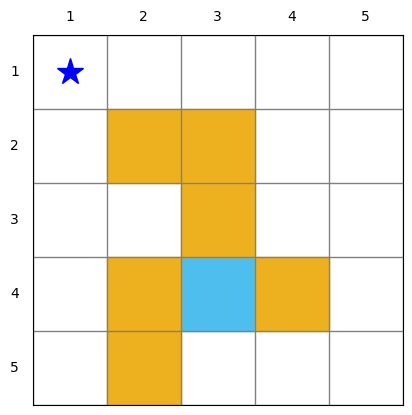

<Figure size 640x480 with 0 Axes>

In [5]:
env.render()
env.add_policy(agent.policy)
env.add_state_values(agent.values)
env.render(animation_interval=2)
time.sleep(3)